In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'masoudnickparvar/brain-tumor-mri-dataset'

 98% 146M/149M [00:04<00:00, 41.9MB/s]
100% 149M/149M [00:04<00:00, 37.2MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#Descriminartor, as described in the original paper
def create_disc(disc_ip):
    df = 64
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [ ]:
import cv2
import os

def load_hr_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(128, 128))
            images.append(img)
    return images

def load_lr_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(32, 32))
            images.append(img)
    return images

# Load LR images
lr_images = load_lr_images_from_folder("/content/Training/meningioma")

# Load HR images
hr_images = load_hr_images_from_folder("/content/Training/meningioma")

# Normalize and convert to NumPy arrays
np_lr_images = np.array([lr_i / 255. for lr_i in lr_images])
np_hr_images = np.array([hr_i / 255. for hr_i in hr_images])

# Split data into train and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(np_lr_images, np_hr_images, test_size=0.2, random_state=42)

In [ ]:
np_lr_images = []
np_hr_images = []
for lr_i in lr_images:
    lr_i = lr_i/255.
    np_lr_images.append(np.array(lr_i))
for hr_i in hr_images:
    hr_i = hr_i/255.
    np_hr_images.append(np.array(hr_i))

In [ ]:
np_lr_images = np.array(np_lr_images)
np_hr_images = np.array(np_hr_images)

In [ ]:
lr_train, lr_test, hr_train, hr_test = train_test_split(np_lr_images, np_hr_images,test_size=0.2, random_state=42)

In [ ]:
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block=16)

In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)

In [ ]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [ ]:
vgg = build_vgg((128,128,3))
vgg.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")


In [ ]:
batch_size = 16
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
!mkdir -p saved_model

In [ ]:
epochs = 10
#Enumerate training over epochs
for e in range(epochs):

    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    #Enumerate training over batches.
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

        #First, train the discriminator on fake and real HR images.
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)

        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False

        #Average the discriminator loss, just for reporting purposes.
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/kaggle/working/saved_model/gen_e_"+ str(e+1) +".h5")

  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 1/66 [00:45<49:01, 45.26s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/66 [00:46<20:21, 19.08s/it]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 3/66 [00:46<11:14, 10.70s/it]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 4/66 [00:47<06:58,  6.75s/it]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:48<04:38,  4.56s/it]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 6/66 [00:48<03:13,  3.23s/it]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 7/66 [00:49<02:19,  2.36s/it]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 8/66 [00:49<01:45,  1.82s/it]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:50<01:21,  1.43s/it]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 10/66 [00:51<01:06,  1.19s/it]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 11/66 [00:51<00:55,  1.01s/it]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 12/66 [00:52<00:48,  1.12it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 13/66 [00:53<00:42,  1.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 14/66 [00:53<00:38,  1.35it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 15/66 [00:54<00:35,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/66 [00:54<00:34,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 17/66 [00:55<00:32,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:56<00:31,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 19/66 [00:56<00:30,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 20/66 [00:57<00:29,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 21/66 [00:58<00:29,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 22/66 [00:58<00:30,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 23/66 [00:59<00:30,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 24/66 [01:00<00:28,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 25/66 [01:00<00:26,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 26/66 [01:01<00:25,  1.58it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 27/66 [01:01<00:24,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [01:02<00:23,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 29/66 [01:03<00:23,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [01:03<00:22,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 31/66 [01:04<00:21,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/66 [01:05<00:20,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 33/66 [01:05<00:20,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 34/66 [01:06<00:19,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 35/66 [01:06<00:19,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 36/66 [01:07<00:19,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 37/66 [01:08<00:18,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [01:08<00:17,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [01:09<00:16,  1.59it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 40/66 [01:10<00:16,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 41/66 [01:10<00:16,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 42/66 [01:11<00:16,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [01:12<00:15,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 44/66 [01:12<00:14,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [01:13<00:13,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 46/66 [01:14<00:12,  1.60it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 47/66 [01:14<00:12,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 48/66 [01:15<00:11,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [01:15<00:10,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 50/66 [01:16<00:10,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 51/66 [01:17<00:09,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 52/66 [01:17<00:08,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 53/66 [01:18<00:08,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 54/66 [01:19<00:07,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [01:19<00:07,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 56/66 [01:20<00:06,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 57/66 [01:21<00:05,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 58/66 [01:21<00:05,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 59/66 [01:22<00:04,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 60/66 [01:23<00:04,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 61/66 [01:23<00:03,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [01:24<00:02,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [01:25<00:02,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [01:25<00:01,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 65/66 [01:26<00:00,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [01:26<00:00,  1.32s/it]


epoch: 1 g_loss: 89.35837809244792 d_loss: [3.69466938 0.88920455]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 1/66 [00:00<00:42,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/66 [00:01<00:42,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 3/66 [00:01<00:40,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/66 [00:02<00:38,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:03<00:37,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 6/66 [00:03<00:37,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 7/66 [00:04<00:36,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:04<00:35,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 9/66 [00:05<00:35,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 10/66 [00:06<00:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 11/66 [00:07<00:37,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 12/66 [00:07<00:37,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 13/66 [00:08<00:35,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 14/66 [00:09<00:33,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 15/66 [00:09<00:33,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 16/66 [00:10<00:31,  1.56it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 17/66 [00:10<00:31,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 18/66 [00:11<00:31,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 19/66 [00:12<00:29,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 20/66 [00:12<00:28,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 21/66 [00:13<00:28,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:27,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:14<00:26,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 24/66 [00:15<00:25,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:15<00:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:16<00:24,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:24,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [00:17<00:23,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 29/66 [00:18<00:23,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 30/66 [00:19<00:24,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 31/66 [00:19<00:23,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 32/66 [00:20<00:22,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 33/66 [00:21<00:21,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 34/66 [00:21<00:21,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 35/66 [00:22<00:20,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 36/66 [00:23<00:19,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 37/66 [00:23<00:18,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:24<00:17,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 39/66 [00:25<00:17,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:25<00:16,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 41/66 [00:26<00:16,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 42/66 [00:27<00:16,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 43/66 [00:27<00:15,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 44/66 [00:28<00:14,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 45/66 [00:28<00:13,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 46/66 [00:29<00:12,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 47/66 [00:30<00:14,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 48/66 [00:31<00:15,  1.17it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [00:32<00:13,  1.27it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 50/66 [00:32<00:12,  1.32it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:33<00:10,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 52/66 [00:34<00:09,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 54/66 [00:35<00:08,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 55/66 [00:36<00:07,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 57/66 [00:37<00:05,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 58/66 [00:38<00:05,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 59/66 [00:38<00:04,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 60/66 [00:39<00:03,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 61/66 [00:40<00:03,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [00:40<00:02,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [00:41<00:01,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 64/66 [00:42<00:01,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 65/66 [00:43<00:00,  1.25it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [00:43<00:00,  1.51it/s]


epoch: 2 g_loss: 32.00109132130941 d_loss: [0.31645289 0.97301136]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/66 [00:00<00:43,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 2/66 [00:01<00:41,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/66 [00:01<00:40,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 4/66 [00:02<00:39,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/66 [00:03<00:39,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 6/66 [00:03<00:38,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:38,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:38,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:05<00:38,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 10/66 [00:06<00:36,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 11/66 [00:07<00:35,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 12/66 [00:07<00:35,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 13/66 [00:08<00:34,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 14/66 [00:09<00:33,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 15/66 [00:09<00:33,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 16/66 [00:10<00:33,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 17/66 [00:11<00:33,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:32,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 19/66 [00:12<00:31,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 20/66 [00:13<00:30,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 21/66 [00:13<00:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:15<00:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:15<00:26,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:25,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:16<00:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:24,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [00:18<00:23,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 29/66 [00:18<00:23,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 30/66 [00:19<00:22,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 31/66 [00:20<00:21,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/66 [00:20<00:21,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 33/66 [00:21<00:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 34/66 [00:22<00:20,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 35/66 [00:22<00:20,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 36/66 [00:23<00:21,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 37/66 [00:24<00:19,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 38/66 [00:24<00:18,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [00:25<00:17,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:25<00:16,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 41/66 [00:26<00:15,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:27<00:15,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 43/66 [00:27<00:14,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 44/66 [00:28<00:13,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:29<00:13,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 46/66 [00:29<00:12,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 47/66 [00:30<00:11,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:30<00:11,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 49/66 [00:31<00:10,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 50/66 [00:32<00:09,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:32<00:09,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 52/66 [00:33<00:08,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 54/66 [00:34<00:08,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 55/66 [00:35<00:07,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 57/66 [00:36<00:05,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 58/66 [00:37<00:05,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 59/66 [00:38<00:04,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 60/66 [00:38<00:03,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 61/66 [00:39<00:03,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 62/66 [00:39<00:02,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [00:40<00:02,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:41<00:01,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 65/66 [00:41<00:00,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [00:42<00:00,  1.55it/s]


epoch: 3 g_loss: 21.508878650087297 d_loss: [0.09628366 0.98910985]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/66 [00:00<00:39,  1.63it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 2/66 [00:01<00:40,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/66 [00:01<00:40,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/66 [00:02<00:39,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 5/66 [00:03<00:41,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 6/66 [00:03<00:41,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:40,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:05<00:37,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 10/66 [00:06<00:36,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 11/66 [00:07<00:35,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 12/66 [00:07<00:34,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 13/66 [00:08<00:33,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 14/66 [00:09<00:33,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 15/66 [00:09<00:32,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/66 [00:10<00:31,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:31,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:30,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 19/66 [00:12<00:29,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 20/66 [00:12<00:29,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 21/66 [00:13<00:28,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:28,  1.56it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 23/66 [00:14<00:28,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 24/66 [00:15<00:29,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:29,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:17<00:27,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:26,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [00:18<00:25,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 29/66 [00:19<00:23,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [00:19<00:22,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 31/66 [00:20<00:22,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/66 [00:20<00:21,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 33/66 [00:21<00:20,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 34/66 [00:22<00:20,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 35/66 [00:22<00:19,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 36/66 [00:23<00:18,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 37/66 [00:24<00:18,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:24<00:17,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [00:25<00:16,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:25<00:16,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 41/66 [00:26<00:15,  1.58it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 42/66 [00:27<00:15,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 43/66 [00:27<00:15,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 44/66 [00:28<00:14,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:29<00:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 46/66 [00:29<00:13,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 47/66 [00:30<00:12,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:31<00:11,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 49/66 [00:31<00:10,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 50/66 [00:32<00:10,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 51/66 [00:33<00:09,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 52/66 [00:33<00:08,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 54/66 [00:34<00:07,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [00:35<00:06,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 57/66 [00:36<00:05,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 58/66 [00:37<00:04,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 59/66 [00:37<00:04,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 60/66 [00:38<00:03,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 61/66 [00:39<00:03,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 62/66 [00:40<00:02,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [00:40<00:02,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:41<00:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 65/66 [00:42<00:00,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 66/66 [00:42<00:00,  1.55it/s]


epoch: 4 g_loss: 18.20439233201923 d_loss: [0.10575617 0.99147727]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 1/66 [00:00<00:41,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/66 [00:01<00:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/66 [00:01<00:40,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/66 [00:02<00:40,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/66 [00:03<00:39,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 6/66 [00:03<00:39,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:40,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:38,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 9/66 [00:05<00:37,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 10/66 [00:06<00:36,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 11/66 [00:07<00:35,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 12/66 [00:07<00:36,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 13/66 [00:08<00:37,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 14/66 [00:09<00:36,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 15/66 [00:10<00:34,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/66 [00:10<00:33,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:32,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:31,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 19/66 [00:12<00:30,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 20/66 [00:13<00:29,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 21/66 [00:13<00:28,  1.59it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 22/66 [00:14<00:27,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:15<00:26,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:15<00:26,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:25,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:16<00:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:24,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [00:18<00:24,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 29/66 [00:18<00:23,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 30/66 [00:19<00:24,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 31/66 [00:20<00:24,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 32/66 [00:21<00:23,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 33/66 [00:21<00:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 34/66 [00:22<00:21,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 35/66 [00:22<00:19,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 36/66 [00:23<00:19,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 37/66 [00:24<00:18,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:24<00:17,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [00:25<00:16,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:26<00:16,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 41/66 [00:26<00:15,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:27<00:15,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [00:27<00:14,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 44/66 [00:28<00:13,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:29<00:13,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 46/66 [00:29<00:12,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 47/66 [00:30<00:12,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 48/66 [00:31<00:11,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 49/66 [00:31<00:11,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 50/66 [00:32<00:10,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:33<00:10,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 52/66 [00:34<00:09,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 54/66 [00:35<00:07,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [00:35<00:07,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 57/66 [00:37<00:05,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 58/66 [00:37<00:05,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 59/66 [00:38<00:04,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 60/66 [00:39<00:03,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 61/66 [00:39<00:03,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [00:40<00:02,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [00:40<00:01,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:41<00:01,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 65/66 [00:42<00:00,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 66/66 [00:42<00:00,  1.54it/s]


epoch: 5 g_loss: 16.543799992763635 d_loss: [0.11167489 0.99100379]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 1/66 [00:00<00:53,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/66 [00:01<00:51,  1.24it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/66 [00:02<00:46,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/66 [00:02<00:43,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:03<00:41,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 6/66 [00:04<00:40,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:39,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:37,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:06<00:37,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 10/66 [00:06<00:36,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 11/66 [00:07<00:35,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 12/66 [00:08<00:34,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 13/66 [00:08<00:33,  1.58it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 14/66 [00:09<00:33,  1.57it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 15/66 [00:09<00:32,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/66 [00:10<00:31,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:30,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:30,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 19/66 [00:12<00:31,  1.48it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 20/66 [00:13<00:31,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 21/66 [00:13<00:30,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:15<00:28,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 24/66 [00:15<00:27,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:26,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 26/66 [00:17<00:25,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:24,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 28/66 [00:18<00:24,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 29/66 [00:19<00:23,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 30/66 [00:19<00:22,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 31/66 [00:20<00:22,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 32/66 [00:20<00:21,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 33/66 [00:21<00:20,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 34/66 [00:22<00:19,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 35/66 [00:22<00:19,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 36/66 [00:23<00:18,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 37/66 [00:24<00:18,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 38/66 [00:24<00:19,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 39/66 [00:25<00:18,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:26<00:17,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 41/66 [00:26<00:16,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:27<00:15,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [00:28<00:14,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 44/66 [00:28<00:14,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:29<00:13,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 46/66 [00:30<00:12,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 47/66 [00:30<00:11,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:31<00:11,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [00:31<00:10,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 50/66 [00:32<00:10,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:33<00:09,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 52/66 [00:33<00:08,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 54/66 [00:35<00:07,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 55/66 [00:35<00:06,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 57/66 [00:37<00:06,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 58/66 [00:37<00:05,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 59/66 [00:38<00:04,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 60/66 [00:39<00:04,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 61/66 [00:39<00:03,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [00:40<00:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 63/66 [00:41<00:01,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 64/66 [00:41<00:01,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 65/66 [00:42<00:00,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [00:43<00:00,  1.53it/s]


epoch: 6 g_loss: 15.603684757695053 d_loss: [0.2718393  0.98106061]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 1/66 [00:00<00:43,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/66 [00:01<00:40,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/66 [00:01<00:39,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 4/66 [00:02<00:38,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 5/66 [00:03<00:38,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 6/66 [00:03<00:38,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:37,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 8/66 [00:05<00:39,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 9/66 [00:05<00:39,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 10/66 [00:06<00:37,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 11/66 [00:07<00:36,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 12/66 [00:07<00:35,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 13/66 [00:08<00:34,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 14/66 [00:09<00:33,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 15/66 [00:09<00:32,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 16/66 [00:10<00:32,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:31,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:30,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 19/66 [00:12<00:30,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 20/66 [00:13<00:29,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 21/66 [00:13<00:28,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 22/66 [00:14<00:27,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 23/66 [00:14<00:26,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:15<00:26,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:25,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 26/66 [00:16<00:26,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 27/66 [00:17<00:26,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 28/66 [00:18<00:25,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 29/66 [00:18<00:24,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [00:19<00:23,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 31/66 [00:20<00:22,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 32/66 [00:20<00:22,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 33/66 [00:21<00:21,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 34/66 [00:22<00:20,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 35/66 [00:22<00:20,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 36/66 [00:23<00:19,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 37/66 [00:24<00:18,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:24<00:17,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [00:25<00:17,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:25<00:16,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 41/66 [00:26<00:16,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:27<00:15,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [00:27<00:14,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 44/66 [00:28<00:14,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 45/66 [00:29<00:13,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 46/66 [00:29<00:13,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 47/66 [00:30<00:12,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:31<00:11,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [00:31<00:11,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 50/66 [00:32<00:10,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:33<00:09,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 52/66 [00:33<00:08,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 53/66 [00:34<00:08,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 54/66 [00:35<00:07,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [00:35<00:06,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 56/66 [00:36<00:06,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 57/66 [00:36<00:05,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 58/66 [00:37<00:05,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 59/66 [00:38<00:04,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 60/66 [00:38<00:03,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 61/66 [00:39<00:03,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [00:40<00:02,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 63/66 [00:41<00:02,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 64/66 [00:41<00:01,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 65/66 [00:42<00:00,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [00:43<00:00,  1.53it/s]


epoch: 7 g_loss: 14.742986245588822 d_loss: [0.17562561 0.98674242]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 1/66 [00:00<00:43,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/66 [00:01<00:42,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 3/66 [00:01<00:41,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 4/66 [00:02<00:39,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:03<00:39,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 6/66 [00:03<00:39,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 7/66 [00:04<00:38,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:37,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:05<00:37,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 10/66 [00:06<00:38,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 11/66 [00:07<00:36,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 12/66 [00:07<00:35,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 13/66 [00:08<00:34,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 14/66 [00:09<00:34,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 15/66 [00:10<00:36,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 16/66 [00:10<00:37,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:35,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:12<00:33,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 19/66 [00:12<00:31,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 20/66 [00:13<00:31,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 21/66 [00:14<00:30,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:28,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:15<00:28,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:16<00:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:16<00:26,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:17<00:25,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 27/66 [00:17<00:24,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 28/66 [00:18<00:24,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 29/66 [00:19<00:23,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [00:19<00:23,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 31/66 [00:20<00:22,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 32/66 [00:21<00:22,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 33/66 [00:21<00:22,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 34/66 [00:22<00:22,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 35/66 [00:23<00:21,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 36/66 [00:24<00:20,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 37/66 [00:24<00:19,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:25<00:18,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 39/66 [00:26<00:18,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:26<00:17,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 41/66 [00:27<00:16,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:28<00:16,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [00:28<00:15,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 44/66 [00:29<00:14,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:30<00:14,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 46/66 [00:30<00:13,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 47/66 [00:31<00:12,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 48/66 [00:31<00:11,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 49/66 [00:32<00:11,  1.50it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 50/66 [00:33<00:11,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 51/66 [00:34<00:10,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 52/66 [00:34<00:10,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 53/66 [00:35<00:09,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 54/66 [00:36<00:08,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [00:36<00:07,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 56/66 [00:37<00:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 57/66 [00:38<00:06,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 58/66 [00:38<00:05,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 59/66 [00:39<00:04,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 60/66 [00:40<00:04,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 61/66 [00:40<00:03,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 62/66 [00:41<00:02,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 63/66 [00:42<00:01,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:42<00:01,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 65/66 [00:43<00:00,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 66/66 [00:44<00:00,  1.50it/s]


epoch: 8 g_loss: 14.190146561824914 d_loss: [0.07749832 0.99195076]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 1/66 [00:00<00:43,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/66 [00:01<00:47,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 3/66 [00:02<00:47,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 4/66 [00:02<00:43,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:03<00:41,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 6/66 [00:04<00:40,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 7/66 [00:04<00:39,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 8/66 [00:05<00:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 9/66 [00:06<00:37,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 10/66 [00:06<00:37,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 11/66 [00:07<00:35,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 12/66 [00:08<00:35,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 13/66 [00:08<00:34,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 14/66 [00:09<00:33,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 15/66 [00:10<00:33,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 16/66 [00:10<00:33,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:32,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:31,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 19/66 [00:12<00:33,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 20/66 [00:13<00:32,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 21/66 [00:14<00:33,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:15<00:31,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 23/66 [00:15<00:30,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:16<00:28,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 25/66 [00:17<00:28,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 26/66 [00:17<00:26,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 27/66 [00:18<00:25,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 28/66 [00:18<00:25,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 29/66 [00:19<00:24,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [00:20<00:23,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 31/66 [00:20<00:22,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/66 [00:21<00:21,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 33/66 [00:22<00:21,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 34/66 [00:22<00:20,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 35/66 [00:23<00:19,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 36/66 [00:24<00:19,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 37/66 [00:24<00:19,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 38/66 [00:25<00:19,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 39/66 [00:26<00:18,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:26<00:17,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 41/66 [00:27<00:16,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 42/66 [00:28<00:15,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 43/66 [00:28<00:15,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 44/66 [00:29<00:14,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:30<00:13,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 46/66 [00:30<00:13,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 47/66 [00:31<00:12,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:32<00:11,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [00:32<00:11,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 50/66 [00:33<00:10,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 51/66 [00:34<00:09,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 52/66 [00:34<00:09,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 53/66 [00:35<00:08,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 54/66 [00:36<00:07,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 55/66 [00:36<00:07,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 56/66 [00:37<00:07,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 57/66 [00:38<00:06,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 58/66 [00:38<00:05,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 59/66 [00:39<00:04,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 60/66 [00:40<00:04,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 61/66 [00:40<00:03,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 62/66 [00:41<00:02,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 63/66 [00:42<00:01,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:42<00:01,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 65/66 [00:43<00:00,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 66/66 [00:44<00:00,  1.50it/s]


epoch: 9 g_loss: 13.75797364206025 d_loss: [0.21925148 0.97964015]


  0%|          | 0/66 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 1/66 [00:00<00:43,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 2/66 [00:01<00:41,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 3/66 [00:01<00:41,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 4/66 [00:02<00:39,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 5/66 [00:03<00:38,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 6/66 [00:03<00:38,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 7/66 [00:04<00:40,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 8/66 [00:05<00:40,  1.44it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 9/66 [00:06<00:41,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 10/66 [00:06<00:38,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 11/66 [00:07<00:37,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 12/66 [00:08<00:36,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 13/66 [00:08<00:35,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 14/66 [00:09<00:34,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 15/66 [00:09<00:33,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 16/66 [00:10<00:32,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 17/66 [00:11<00:32,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 18/66 [00:11<00:31,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 19/66 [00:12<00:31,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 20/66 [00:13<00:30,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 21/66 [00:13<00:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 22/66 [00:14<00:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 23/66 [00:15<00:28,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 24/66 [00:15<00:27,  1.53it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 25/66 [00:16<00:28,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 26/66 [00:17<00:27,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 27/66 [00:18<00:26,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 28/66 [00:18<00:25,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 29/66 [00:19<00:24,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 30/66 [00:20<00:23,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 31/66 [00:20<00:23,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 32/66 [00:21<00:22,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 33/66 [00:22<00:21,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 34/66 [00:22<00:21,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 35/66 [00:23<00:20,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 36/66 [00:24<00:19,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 37/66 [00:24<00:18,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 38/66 [00:25<00:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 39/66 [00:25<00:17,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 40/66 [00:26<00:17,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 41/66 [00:27<00:16,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 42/66 [00:28<00:16,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 43/66 [00:28<00:16,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 44/66 [00:29<00:15,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 45/66 [00:30<00:14,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 46/66 [00:30<00:13,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 47/66 [00:31<00:12,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 48/66 [00:32<00:12,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 49/66 [00:32<00:11,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 50/66 [00:33<00:10,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 51/66 [00:34<00:09,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 52/66 [00:34<00:09,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 53/66 [00:35<00:08,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 54/66 [00:36<00:07,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 55/66 [00:36<00:07,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 56/66 [00:37<00:06,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 57/66 [00:38<00:05,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 58/66 [00:38<00:05,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 59/66 [00:39<00:04,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 60/66 [00:40<00:04,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 61/66 [00:40<00:03,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 62/66 [00:41<00:02,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 63/66 [00:42<00:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 64/66 [00:42<00:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 65/66 [00:43<00:00,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 66/66 [00:44<00:00,  1.50it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch: 10 g_loss: 13.327097907210842 d_loss: [2.81784301e-04 1.00000000e+00]


In [ ]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/kaggle/working/saved_model/gen_e_10.h5', compile=False)

In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

1/1 [==============================] - 1s 1s/step


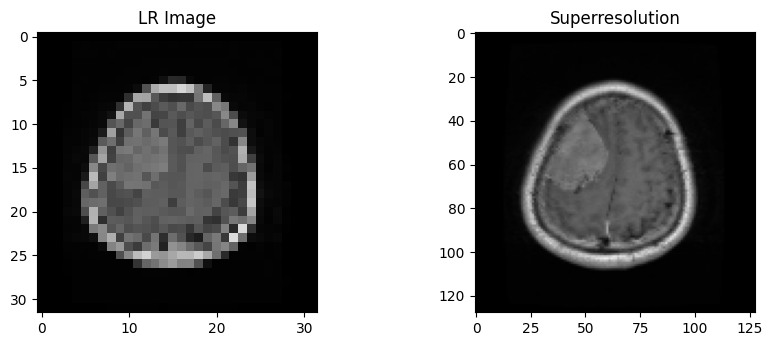

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)

plt.title('Superresolution')
plt.imshow(tar_image[0,:,:,:])

plt.show()

<ipython-input-23-21f79b6edfc2>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(source, label='Real Images', hist=True, color='#fc0328', ax=axs)
<ipython-input-23-21f79b6edfc2>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated, label='Generated Images', hist=True, color='#0c06c7', ax=a

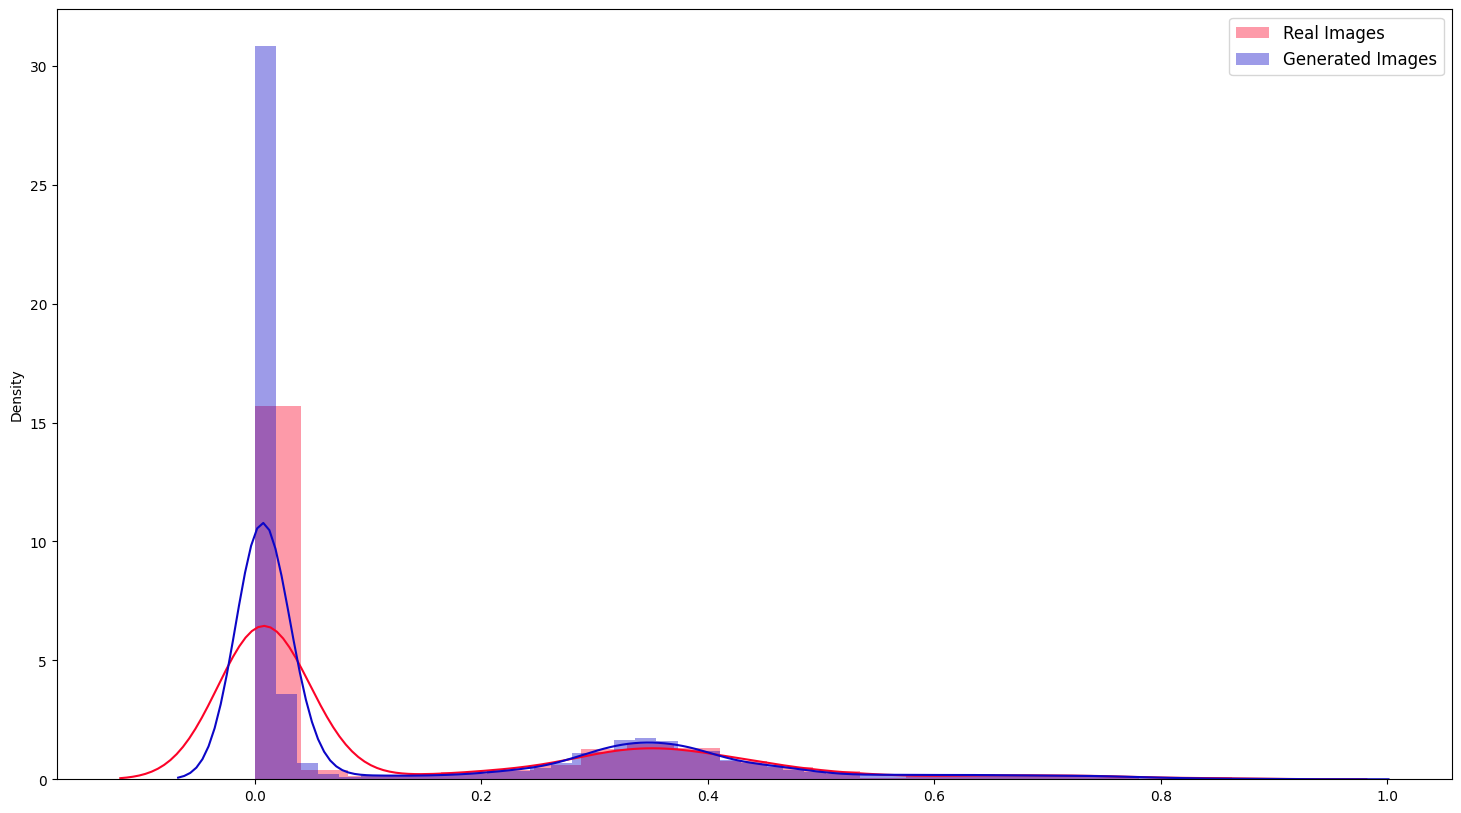

In [ ]:
import seaborn as sns
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

source = src_image.reshape(1, -1)
generated = tar_image.reshape(1, -1)

sns.distplot(source, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

# sns.histplot(source, label='Real Images',  color='#fc0328', ax=axs)
# sns.histplot(generated, label='Generated Images', color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()



In [ ]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from scipy.linalg import sqrtm

In [ ]:
# prompt: Generate FID Score for the above code
import tensorflow as tf
import numpy as np
from scipy import linalg
from keras import backend as K

def calculate_fid(model, images1, images2):
  # Calculate the activations of the pool_3 layer for both sets of images
  act1 = model.predict(images1)
  act2 = model.predict(images2)

  # Calculate the mean and covariance matrix for each set of activations
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

  # Calculate the FID score
  ssdiff = np.sum((mu1 - mu2)**2.0)
  covmean = sqrtm(sigma1.dot(sigma2))
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

  return -1*fid

# Load the InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

# Preprocess the images
images1 = preprocess_input(lr_test)
images2 = preprocess_input(hr_test)

images1 = tf.image.resize(lr_test, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)
images2 = tf.image.resize(hr_test, size=(128, 128), method=tf.image.ResizeMethod.BILINEAR)
# Calculate the FID score
fid = calculate_fid(inception_model, images1, images2)

print("FID score:", fid)


9/9 [==============================] - 0s 30ms/step
FID score: 2.5497529210462694e+85


In [ ]:
# prompt: Generate Inception Score for the lr_test and hr_test

import numpy as np
def calculate_inception_score(images, n_split=10):
    # Load the InceptionV3 model
    inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

    # Preprocess the images
    images = preprocess_input(images)

    # Calculate the activations of the pool_3 layer for the images
    activations = inception_model.predict(images)

    # Calculate the mean and covariance matrix for the activations
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)

    # Calculate the KL divergence between the activations and a normal distribution
    p_y = np.exp(np.random.multivariate_normal(mu, sigma, n_split))
    kl_d = np.mean(np.log(p_y) - np.log(np.mean(p_y, axis=0)))

    # Calculate the Inception Score
    is_score = np.exp(kl_d)

    return is_score

# Calculate the Inception Score for the LR and HR images
lr_is_score = calculate_inception_score(images1)
hr_is_score = calculate_inception_score(images2)

print((lr_is_score,hr_is_score))
# print("HR Inception Score:", hr_is_score)


9/9 [==============================] - 1s 31ms/step
(0.9999996291088828, 0.9999990513618038)
